64901.10931640885
64901.10931640885
390607.34934873943
2502795.21230333
64901.10931640885
1275401.9096464254
205203.32826963864
85873.58703954786
96992.59200448522
65017.65878127629
64559.92480705995
64560.02187692339
64559.87608220148
64559.87608220148
1191933.6667594688
2494550.1143098627
64559.87608220148
834867.6441015311
390630.5258234604
61378.62252946175
59546.29828542827
205333.14886321785
56245.17873971448
56246.45562082346
56245.65899888812
56245.17873971448
595043.4470045195
7058648.887322662
56245.17873971448
1811973.1666538315
319017.8550369765
100702.92560927439
273660.2867590635
54532.473946143524
53382.78471678142
86037.46688278131
53086.82849624919
53086.81035084226
53087.46579683044
53086.81035084226
6437669.1272503715
7441616.6333968565
53086.81035084226
3134757.90649484
3280504.226586887
153906.72211999298
42320.978370780125
37421.91508002415
37280.21672078324
37278.41616842521
37280.29526745003
37278.41616842521
34228.11857043849
51968.01896222474
34228.11857043849

/home/marcel/.local/lib/python3.8/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/home/marcel/.local/lib/python3.8/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 50883
    # data points      = 5280
    # variables        = 41
    chi-square         = 5308.58719
    reduced chi-square = 1.01328253
    Akaike info crit   = 110.510080
    Bayesian info crit = 379.949016
##  Warning: uncertainties could not be estimated:
[[Variables]]
    M_Es:       -9.16763530 +/- 0.01778130 (0.19%) (init = -10.6449), model_value = -10.6449
    X_Es:       -22.3435865 +/- 0.01348912 (0.06%) (init = -20.93123), model_value = -20.93123
    M_Ep:       -7.30992886 +/- 4.6556e-04 (0.01%) (init = -7.606622), model_value = -7.606622
    X_Ep:       -13.9159602 +/-        nan (nan%) (init = -13.46862), model_value = -13.46862
    M_Ese:      -1.2818e-04 +/- 5.3691e-06 (4.19%) (init = -3.20562), model_value = -3.20562
    X_Ese:      -5.82380271 +/- 0.00395524 (0.07%) (init = -8.361321), model_value = -8.361321
    one_ss:     -0.85143160 +/-        nan (nan%) (init = -0.9308703), model_value = -

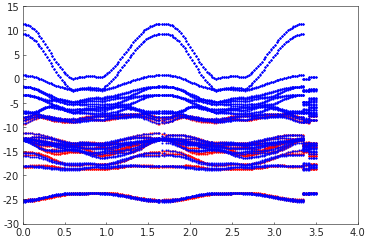

In [142]:
import pybinding as pb
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, pi, cos, sin
from scipy import integrate
import matplotlib.mlab as mlab
import matplotlib.gridspec as gs
import sys
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit

pb.pltutils.use_style()


"""
TO DO:
1-strain in c
	a. new c in each layer
	b. Bond 5 normalization

"""


"""Hopping projections
"""
def s_px(hopping,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return hopping*cos(a)*cos(b)

def s_py(hopping,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return -hopping*sin(a)*cos(b)
	
def s_pz(hopping,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return hopping*sin(b)
	
def pxpx(h_sigma,h_pi,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return h_sigma*cos(a)**2*cos(b)**2+h_pi*(sin(a)**2+cos(a)**2*sin(b)**2)
	
def pypx(h_sigma,h_pi,angle=(0,0)):
	return pxpy(h_sigma,h_pi,angle)
	
def pxpy(h_sigma,h_pi,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return -h_sigma*cos(a)*sin(a)*cos(b)**2+h_pi*(sin(a)*cos(a)+sin(a)*sin(b)-cos(a)*cos(b))

def pxpz(h_sigma,h_pi,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return h_sigma*cos(a)*sin(a)*sin(b)-h_pi*cos(a)*cos(b)*sin(b)
	
def pzpx(h_sigma,h_pi,angle=(0,0)):
	return pxpz(h_sigma,h_pi,angle)
	
def pypy(h_sigma,h_pi,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return h_sigma*sin(a)**2*cos(b)**2+h_pi*(cos(a)**2+sin(a)**2*sin(b)**2)
	
def pypz(h_sigma,h_pi,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return -h_sigma*sin(a)*cos(b)*sin(b)+h_pi*cos(b)*sin(b)*sin(a)
	
def pzpz(h_sigma,h_pi,angle=(0,0)):
	a=2*pi*angle[0]/360
	b=2*pi*angle[1]/360
	return h_sigma*sin(b)**2+h_pi*cos(b)**2

def pzpy(h_sigma,h_pi,angle=(0,0)): 
	return pypz(h_sigma,h_pi,angle)
	
def angles(a1,a2,a3,ref,pos1,pos2,cellpos2):
	x=ref[0]*a1+ref[1]*a2+ref[2]*a3
	x=x/np.linalg.norm(x)
	z=np.array([0,0,1])
	y=np.cross(z,x)
	d=(cellpos2[0]*a1+cellpos2[1]*a2+cellpos2[2]*a3+pos2)-pos1
	dxy=d-np.dot(d,z)*z
	signal=1
	if (d[0] == 0.0 and d[1] == 0.0):
		theta = 0
	else:
		if np.dot(dxy,y) < 0:
			signal = -1
		theta=signal*180*np.arccos(np.dot(dxy,x)/np.linalg.norm(dxy))/pi
	phi=90-180*np.arccos(np.dot(d,z)/np.linalg.norm(d))/pi
	return (theta,phi)
	
def distance(a1,a2,a3,pos1,pos2,cellpos2):
	return  np.linalg.norm((cellpos2[0]*a1+cellpos2[1]*a2+cellpos2[2]*a3+pos2)-pos1)
	
def sp3s_hoppingmatrix(bondparameters,angle):
	return [[bondparameters[0],s_px(bondparameters[1],angle),s_py(bondparameters[1],angle),s_pz(bondparameters[1],angle),bondparameters[5]],
			[-s_px(bondparameters[1],angle),pxpx(bondparameters[2],bondparameters[3],angle),pxpy(bondparameters[2],bondparameters[3],angle),pxpz(bondparameters[2],bondparameters[3],angle),-s_px(bondparameters[4],angle)],
			[-s_py(bondparameters[1],angle),pypx(bondparameters[2],bondparameters[3],angle),pypy(bondparameters[2],bondparameters[3],angle),pypz(bondparameters[2],bondparameters[3],angle),-s_py(bondparameters[4],angle)],
			[-s_pz(bondparameters[1],angle),pzpx(bondparameters[2],bondparameters[3],angle),pzpy(bondparameters[2],bondparameters[3],angle),pzpz(bondparameters[2],bondparameters[3],angle),-s_pz(bondparameters[4],angle)],
			[bondparameters[5],s_px(bondparameters[4],angle),s_py(bondparameters[4],angle),s_pz(bondparameters[4],angle),bondparameters[6]]]

class PTMC:
	pass

class InSe(PTMC):
	#lattice
	a = 0.40231918225
	c = 0.8469198513
	z1 = 3*0.060940054
	z2 = 3*0.111797495

	#on-site therms
	M_Es = -12.97
	X_Es = -21.73
	M_Ep = -6.73
	X_Ep = -10.82
	M_Ese = -2.34
	X_Ese = -4.89

	#bond lenght
	d1=0.26580159178743173
	d2=0.27881874425332515
	d3=0.40231918225
	d4=0.40231918224999996

	
	#bond sp3s* parameters
	bondpar_1=np.array([-1.001,2.105,3.290,-0.421,0.913,0,0])
	bondpar_2=np.array([-1.701,1.493,2.327,-0.968,1.896,0,0])
	bondpar_3=np.array([-0.133,0.293,1.119,0.204,0.597,0,0])
	bondpar_4=np.array([0.082,0.233,0.114,-0.109, -0.220,0,0])
	bondpar_5=np.array([-0.055,-0.147,0.582,-0.159,-0.051,0,0])

class GaSe(PTMC):
	#lattice
	a = 0.37618898094
	c = 0.7876028792
	z1 = 3*0.068891933
	z2 = 3*0.117076586
	#on-site therms
	M_Es = -12.63
	X_Es = -22.60
	M_Ep = -6.44
	X_Ep = -12.30
	M_Ese = -2.60
	X_Ese = -4.89
	
	#bond lenght
	d1=0.2452239643457275
	d2=0.23434374187696183
	d3=0.37618898094
	d4=0.3761889809399999

	
	#bond sp3s* parameters
	bondpar_1=np.array([-0.988,2.057,2.803,-0.533, 0.822,-0.333,2.253])
	bondpar_2=np.array([-2.241,1.881,2.462,-1.013,0.0,-0.279,-0.240])
	bondpar_3=np.array([-0.102,0.085,0.774,-0.115,0.561,0.007,0.415])
	bondpar_4=np.array([-0.133,0.242, 0.330,-0.075, 0.488,-0.386,1.110])
	bondpar_5=np.array([-0.05,0.051,0.483,-0.149,0.249,-0.010,-0.125])

class fitting(PTMC):
	#bond lenght
	d1=0
	d2=0
	d3=0
	d4=0

	def __init__(self,pars,a,c,z1,z2):
		self.a=a
		self.c=c
		self.z1=z1
		self.z2=z2
		self.M_Es = pars['M_Es']
		self.X_Es = pars['X_Es']
		self.M_Ep = pars['M_Ep']
		self.X_Ep = pars['X_Ep']
		self.M_Ese = pars['M_Ese']
		self.X_Ese = pars['X_Ese']
		self.bondpar_1=np.array([pars['one_ss'],pars['one_sp'],pars['one_pp_s'],pars['one_pp_p'],pars['one_sep'],pars['one_ses'],pars['one_sese']])
		self.bondpar_2=np.array([pars['two_ss'],pars['two_sp'],pars['two_pp_s'],pars['two_pp_p'],pars['two_sep'],pars['two_ses'],pars['two_sese']])
		self.bondpar_3=np.array([pars['three_ss'],pars['three_sp'],pars['three_pp_s'],pars['three_pp_p'],pars['three_sep'],pars['three_ses'],pars['three_sese']])
		self.bondpar_4=np.array([pars['four_ss'],pars['four_sp'],pars['four_pp_s'],pars['four_pp_p'],pars['four_sep'],pars['four_ses'],pars['four_sese']])
		self.bondpar_5=np.array([pars['five_ss'],pars['five_sp'],pars['five_pp_s'],pars['five_pp_p'],pars['five_sep'],pars['five_ses'],pars['five_sese']])

class Layer:
	def __init__(self,material,a,parity,layerstart=0,strained=True):
		self.a1l=np.array([a/2, (a/2) * sqrt(3),0])
		self.a2l=np.array([-a/2, (a/2) * sqrt(3),0])
		self.a3l=np.array([0,0,material.c])
		self.zero=np.array([0,0,layerstart])
		self.c=material.c

		if parity % 3 == 0:
			self.X1pos = (2*(self.a1l+self.a2l)/3+(material.z1)*self.a3l+self.zero)
			self.X2pos = (2*(self.a1l+self.a2l)/3+(1-material.z1)*self.a3l+self.zero)
			self.M1pos = (1*(self.a1l+self.a2l)+(material.z2)*self.a3l+self.zero)
			self.M2pos = (1*(self.a1l+self.a2l)+(1-material.z2)*self.a3l+self.zero)

			#bond lenght
			self.d2 = distance(self.a1l,self.a2l,self.a3l,self.M1pos,self.M2pos,[0,0,0])
			self.d1 = distance(self.a1l,self.a2l,self.a3l,self.X1pos,self.M1pos,[0,0,0])
			self.d3 = distance(self.a1l,self.a2l,self.a3l,self.M1pos,self.M1pos,[0,-1,0])
			self.d4 = distance(self.a1l,self.a2l,self.a3l,self.X1pos,self.X1pos,[0,1,0])

		elif parity % 3 == 1:
			self.X1pos =((material.z1)*self.a3l+self.zero)
			self.X2pos = ((1-material.z1)*self.a3l+self.zero)
			self.M1pos = ((self.a1l+self.a2l)/3+(material.z2)*self.a3l+self.zero)
			self.M2pos = ((self.a1l+self.a2l)/3+(1-material.z2)*self.a3l+self.zero)

			#bond lenght
			self.d2 = distance(self.a1l,self.a2l,self.a3l,self.M1pos,self.M2pos,[0,0,0])
			self.d1 = distance(self.a1l,self.a2l,self.a3l,self.X1pos,self.M1pos,[0,-1,0])
			self.d3 = distance(self.a1l,self.a2l,self.a3l,self.M1pos,self.M1pos,[0,-1,0])
			self.d4 = distance(self.a1l,self.a2l,self.a3l,self.X1pos,self.X1pos,[0,1,0])
		else:
			self.X1pos =((self.a1l+self.a2l)/3+(material.z1)*self.a3l+self.zero)
			self.X2pos = ((self.a1l+self.a2l)/3+(1-material.z1)*self.a3l+self.zero)
			self.M1pos = (2*(self.a1l+self.a2l)/3+(material.z2)*self.a3l+self.zero)
			self.M2pos = (2*(self.a1l+self.a2l)/3+(1-material.z2)*self.a3l+self.zero)

			#bond lenght
			self.d2 = distance(self.a1l,self.a2l,self.a3l,self.M1pos,self.M2pos,[0,0,0])
			self.d1 = distance(self.a1l,self.a2l,self.a3l,self.X1pos,self.M1pos,[0,-1,0])
			self.d3 = distance(self.a1l,self.a2l,self.a3l,self.M1pos,self.M1pos,[0,-1,0])
			self.d4 = distance(self.a1l,self.a2l,self.a3l,self.X1pos,self.X1pos,[0,1,0])
	
		#lattice
		self.a = a
		self.c = material.c
		self.z1 = material.z1
		self.z2 = material.z2
		
		#on-site therms
		self.M_Es = material.M_Es
		self.X_Es = material.X_Es
		self.M_Ep = material.M_Ep
		self.X_Ep = material.X_Ep 
		self.M_Ese = material.M_Ese
		self.X_Ese = material.X_Ese

		"""use it to get the d# values
		print('d1='+str(self.d1))
		print('d2='+str(self.d2))
		print('d3='+str(self.d3))
		print('d4='+str(self.d4))"""
		
		#bond sp3s* parameters
		if strained == True:
			self.bondpar_2= material.bondpar_2*(1- 2*(self.d2-material.d2)/material.d2)
			self.bondpar_3= material.bondpar_3*(1- 2*(self.d3-material.d3)/material.d3)
			self.bondpar_1= material.bondpar_1*(1- 2*(self.d1-material.d1)/material.d1)
			self.bondpar_4= material.bondpar_4*(1- 2*(self.d4-material.d4)/material.d4)
			self.bondpar_5= material.bondpar_5
		else:
			self.bondpar_2= material.bondpar_2
			self.bondpar_3= material.bondpar_3
			self.bondpar_1= material.bondpar_1
			self.bondpar_4= material.bondpar_4
			self.bondpar_5= material.bondpar_5


class Stack:
	def calc_c(self,layerlist):
		c=0
		for i in layerlist:
			c += i.c
		return c
	
	def __init__(self,materiallist, a,strained=True):
		self.a = a
		self.materiallist = materiallist
		if len(materiallist) % 3 != 0:
			raise ValueError("gamma polymorph must have multiple of 3 layers!")
		self.c = self.calc_c(materiallist)
		self.filled_c = 0
		self.layerlist = []
		self.a1l=np.array([a/2, (a/2) * sqrt(3),0])
		self.a2l=np.array([-a/2, (a/2) * sqrt(3),0]) 
		self.a3l=np.array([0,0,self.c])
		
		self.lat = pb.Lattice(a1=self.a1l.tolist(), a2=self.a2l.tolist(), a3=self.a3l.tolist())


		for index,material in enumerate(self.materiallist):
			self.layerlist.append(Layer(material,self.a,index,self.filled_c,strained=strained))
			self.filled_c += material.c


		for index,layer in enumerate(self.layerlist):
			self.add_layer(layer,index)


		
		for i in range(len(self.layerlist)):
			if i == (len(self.layerlist)-1):
				if i % 3 == 2:
					self.lat.add_hoppings(
						([0, -1, 1], 'X2-'+str(i), 'X1-'+str(0), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[0].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[0].X1pos,[0,-1,1]))),
						([-1, 0, 1], 'X2-'+str(i), 'X1-'+str(0), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[0].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[0].X1pos,[-1,0,1]))),
						([0, 0, 1], 'X2-'+str(i), 'X1-'+str(0), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[0].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[0].X1pos,[0,0,1]))),
					)
				else:
					print("You should have define a number of layer multiple of 3  - because it is gamma phase")

			else:
				if i % 3 == 0:
					self.lat.add_hoppings(
						([0, 1, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[0,1,0]))),
						([1, 0, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[1,0,0]))),
						([1,1, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[1,1,0]))),
					)
				elif i % 3 == 1: 
					self.lat.add_hoppings(
						([0, -1, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[0,-1,0]))),
						([-1, 0, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[-1,0,0]))),
						([0,0, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[0,0,0]))),
					)
				else:
					self.lat.add_hoppings(
						([0, -1, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[0,-1,0]))),
						([-1, 0, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[-1,0,0]))),
						([0, 0, 0], 'X2-'+str(i), 'X1-'+str(i+1), sp3s_hoppingmatrix((self.layerlist[i].bondpar_5+self.layerlist[i+1].bondpar_5)/2,angles(self.a1l,self.a2l,self.a3l,[1,1,0],self.layerlist[i].X2pos,self.layerlist[i+1].X1pos,[0,0,0]))),
					)
		
		
		
	def add_layer(self,layer,index):

		self.lat.add_sublattices(
			('X1-'+str(index), layer.X1pos.tolist(), [[layer.X_Es,0,0,0,0],
								[0,layer.X_Ep,0,0,0],
								[0,0,layer.X_Ep,0,0],
								[0,0,0,layer.X_Ep,0],
								[0,0,0,0,layer.X_Ese]]),
			('X2-'+str(index), layer.X2pos.tolist(), [[layer.X_Es,0,0,0,0],
								[0,layer.X_Ep,0,0,0],
								[0,0,layer.X_Ep,0,0],
								[0,0,0,layer.X_Ep,0],
								[0,0,0,0,layer.X_Ese]]),
			('M1-'+str(index), layer.M1pos.tolist(), [[layer.M_Es,0,0,0,0],
								[0,layer.M_Ep,0,0,0],
								[0,0,layer.M_Ep,0,0],
								[0,0,0,layer.M_Ep,0],
								[0,0,0,0,layer.M_Ese]]),
			('M2-'+str(index), layer.M2pos.tolist(), [[layer.M_Es,0,0,0,0],
								[0,layer.M_Ep,0,0,0],
								[0,0,layer.M_Ep,0,0],
								[0,0,0,layer.M_Ep,0],
								[0,0,0,0,layer.M_Ese]]),
		)

		if index % 3 == 0:
			self.lat.add_hoppings(
				#Ga-Ga bond 2
				([0, 0, 0], 'M1-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_2,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M2pos,[0,0,0]))),

				# Ga_se Bond 1
				([0, 0, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[0,0,0]))),
				([0, -1, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[0,-1,0]))),
				([-1, 0, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[-1,0,0]))),
				([0, 0, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[0,0,0]))),
				([-1, 0, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[-1,0,0]))),
				([0, -1, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[0,-1,0]))),
				
				# Ga-Ga Bond 3
				([0, -1, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[0,-1,0]))),
				([1, 0, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[1,0,0]))),		
				([1, -1, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[1,-1,0]))),
				([0, -1, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[0,-1,0]))),
				([1, 0, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[1,0,0]))),		
				([1, -1, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[1,-1,0]))),
				
				# Se_se Bond 4
				([0, 1, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[0,1,0]))),
				([1, 0, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[1,0,0]))),
				([1, -1, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[1,-1,0]))),
				([0, 1, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[0,1,0]))),
				([1, 0, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[1,0,0]))),
				([1, -1, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[1,-1,0]))),
			)
		elif index % 3 == 1:
			self.lat.add_hoppings(
				#Metal-Metal Bond 2
				([0, 0, 0], 'M1-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_2,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M2pos,[0,0,0]))),
				

				# Ga_se Bond 1
				([0, 0, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[0,0,0]))),
				([0, -1, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[0,-1,0]))),
				([-1, 0, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[-1,0,0]))),
				([0, 0, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[0,0,0]))),
				([-1, 0, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[0,-1,0]))),
				([0, -1, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[-1,0,0]))),
				
										
				# Ga-Ga Bond 3
				([0, -1, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[0,-1,0]))),
				([1, 0, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[1,0,0]))),		
				([1, -1, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[1,-1,0]))),
				([0, -1, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[0,-1,0]))),
				([1, 0, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[1,0,0]))),		
				([1, -1, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[1,-1,0]))),
				
									
				# Se_se Bond 4
				([0, 1, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[0,1,0]))),
				([1, 0, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[1,0,0]))),
				([1, -1, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[1,-1,0]))),
				([0, 1, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[0,1,0]))),
				([1, 0, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[1,0,0]))),
				([1, -1, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[1,-1,0]))),
			)
		else:
			self.lat.add_hoppings(
				#Metal-Metal Bond 2
				([0, 0, 0], 'M1-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_2,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M2pos,[0,0,0]))),
				

				# Ga_se Bond 1
				([0, 0, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[0,0,0]))),
				([0, -1, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[0,-1,0]))),
				([-1, 0, 0], 'X1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.M1pos,[-1,0,0]))),
				([0, 0, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[0,0,0]))),
				([-1, 0, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[0,-1,0]))),
				([0, -1, 0], 'X2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_1,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.M2pos,[-1,0,0]))),
				
										
				# Ga-Ga Bond 3
				([0, -1, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[0,-1,0]))),
				([1, 0, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[1,0,0]))),		
				([1, -1, 0], 'M1-'+str(index), 'M1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M1pos,layer.M1pos,[1,-1,0]))),
				([0, -1, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[0,-1,0]))),
				([1, 0, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[1,0,0]))),		
				([1, -1, 0], 'M2-'+str(index), 'M2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_3,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.M2pos,layer.M2pos,[1,-1,0]))),
				
									
				# Se_se Bond 4
				([0, 1, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[0,1,0]))),
				([1, 0, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[1,0,0]))),
				([1, -1, 0], 'X1-'+str(index), 'X1-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X1pos,layer.X1pos,[1,-1,0]))),
				([0, 1, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[0,1,0]))),
				([1, 0, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[1,0,0]))),
				([1, -1, 0], 'X2-'+str(index), 'X2-'+str(index), sp3s_hoppingmatrix(layer.bondpar_4,angles(layer.a1l,layer.a2l,layer.a3l,[1,1,0],layer.X2pos,layer.X2pos,[1,-1,0]))),
			)

def apply_scissor(band,last_valence,exp_gap):
	top_valence=np.max(band[last_valence])
	bottom_conduction=np.min(band[last_valence+1])
	gap=bottom_conduction - top_valence
	deltagap=exp_gap-gap
	modified_band = np.array(band)
	for i in range(len(band)):
		if i > last_valence:
			modified_band[i,:] += deltagap
	return modified_band


def residuals(pars,dft,weight,a,c,z1,z2):
	material = fitting(pars,a,c,z1,z2)
	mat = Stack([material,material,material],a,strained=False)
	lattice = mat.lat

	kpoints= np.array([[0.0000000000,0.0000000000,0.5000000000],
			[0.0000000000,0.0185185185,0.5000000000],
			[0.0000000000,0.0370370370,0.5000000000],
			[0.0000000000,0.0555555556,0.5000000000],
			[0.0000000000,0.0740740741,0.5000000000],
			[0.0000000000,0.0925925926,0.5000000000],
			[0.0000000000,0.1111111111,0.5000000000],
			[0.0000000000,0.1296296296,0.5000000000],
			[0.0000000000,0.1481481481,0.5000000000],
			[0.0000000000,0.1666666667,0.5000000000],
			[0.0000000000,0.1851851852,0.5000000000],
			[0.0000000000,0.2037037037,0.5000000000],
			[0.0000000000,0.2222222222,0.5000000000],
			[0.0000000000,0.2407407407,0.5000000000],
			[0.0000000000,0.2592592593,0.5000000000],
			[0.0000000000,0.2777777778,0.5000000000],
			[0.0000000000,0.2962962963,0.5000000000],
			[0.0000000000,0.3148148148,0.5000000000],
			[0.0000000000,0.3333333333,0.5000000000],
			[0.0000000000,0.3518518519,0.5000000000],
			[0.0000000000,0.3703703704,0.5000000000],
			[0.0000000000,0.3888888889,0.5000000000],
			[0.0000000000,0.4074074074,0.5000000000],
			[0.0000000000,0.4259259259,0.5000000000],
			[0.0000000000,0.4444444444,0.5000000000],
			[0.0000000000,0.4629629630,0.5000000000],
			[0.0000000000,0.4814814815,0.5000000000],
			[0.0000000000,0.5000000000,0.5000000000],
			[0.0222220000,0.4888886667,0.5000000000],
			[0.0444440000,0.4777773333,0.5000000000],
			[0.0666660000,0.4666660000,0.5000000000],
			[0.0888880000,0.4555546667,0.5000000000],
			[0.1111100000,0.4444433333,0.5000000000],
			[0.1333320000,0.4333320000,0.5000000000],
			[0.1555540000,0.4222206667,0.5000000000],
			[0.1777760000,0.4111093333,0.5000000000],
			[0.1999980000,0.3999980000,0.5000000000],
			[0.2222200000,0.3888866667,0.5000000000],
			[0.2444420000,0.3777753333,0.5000000000],
			[0.2666640000,0.3666640000,0.5000000000],
			[0.2888860000,0.3555526667,0.5000000000],
			[0.3111080000,0.3444413333,0.5000000000],
			[0.3333300000,0.3333300000,0.5000000000],
			[0.3225774194,0.3225774194,0.5000000000],
			[0.3118248387,0.3118248387,0.5000000000],
			[0.3010722581,0.3010722581,0.5000000000],
			[0.2903196774,0.2903196774,0.5000000000],
			[0.2795670968,0.2795670968,0.5000000000],
			[0.2688145161,0.2688145161,0.5000000000],
			[0.2580619355,0.2580619355,0.5000000000],
			[0.2473093548,0.2473093548,0.5000000000],
			[0.2365567742,0.2365567742,0.5000000000],
			[0.2258041935,0.2258041935,0.5000000000],
			[0.2150516129,0.2150516129,0.5000000000],
			[0.2042990323,0.2042990323,0.5000000000],
			[0.1935464516,0.1935464516,0.5000000000],
			[0.1827938710,0.1827938710,0.5000000000],
			[0.1720412903,0.1720412903,0.5000000000],
			[0.1612887097,0.1612887097,0.5000000000],
			[0.1505361290,0.1505361290,0.5000000000],
			[0.1397835484,0.1397835484,0.5000000000],
			[0.1290309677,0.1290309677,0.5000000000],
			[0.1182783871,0.1182783871,0.5000000000],
			[0.1075258065,0.1075258065,0.5000000000],
			[0.0967732258,0.0967732258,0.5000000000],
			[0.0860206452,0.0860206452,0.5000000000],
			[0.0752680645,0.0752680645,0.5000000000],
			[0.0645154839,0.0645154839,0.5000000000],
			[0.0537629032,0.0537629032,0.5000000000],
			[0.0430103226,0.0430103226,0.5000000000],
			[0.0322577419,0.0322577419,0.5000000000],
			[0.0215051613,0.0215051613,0.5000000000],
			[0.0107525806,0.0107525806,0.5000000000],
			[0.0000000000,0.0000000000,0.5000000000],
			[0.0000000000,0.0000000000,0.3333333333],
			[0.0000000000,0.0000000000,0.1666666667],
			[0.0000000000,0.0000000000,0.0000000000],
			[0.0000000000,0.0185185185,0.0000000000],
			[0.0000000000,0.0370370370,0.0000000000],
			[0.0000000000,0.0555555556,0.0000000000],
			[0.0000000000,0.0740740741,0.0000000000],
			[0.0000000000,0.0925925926,0.0000000000],
			[0.0000000000,0.1111111111,0.0000000000],
			[0.0000000000,0.1296296296,0.0000000000],
			[0.0000000000,0.1481481481,0.0000000000],
			[0.0000000000,0.1666666667,0.0000000000],
			[0.0000000000,0.1851851852,0.0000000000],
			[0.0000000000,0.2037037037,0.0000000000],
			[0.0000000000,0.2222222222,0.0000000000],
			[0.0000000000,0.2407407407,0.0000000000],
			[0.0000000000,0.2592592593,0.0000000000],
			[0.0000000000,0.2777777778,0.0000000000],
			[0.0000000000,0.2962962963,0.0000000000],
			[0.0000000000,0.3148148148,0.0000000000],
			[0.0000000000,0.3333333333,0.0000000000],
			[0.0000000000,0.3518518519,0.0000000000],
			[0.0000000000,0.3703703704,0.0000000000],
			[0.0000000000,0.3888888889,0.0000000000],
			[0.0000000000,0.4074074074,0.0000000000],
			[0.0000000000,0.4259259259,0.0000000000],
			[0.0000000000,0.4444444444,0.0000000000],
			[0.0000000000,0.4629629630,0.0000000000],
			[0.0000000000,0.4814814815,0.0000000000],
			[0.0000000000,0.5000000000,0.0000000000],
			[0.0222220000,0.4888886667,0.0000000000],
			[0.0444440000,0.4777773333,0.0000000000],
			[0.0666660000,0.4666660000,0.0000000000],
			[0.0888880000,0.4555546667,0.0000000000],
			[0.1111100000,0.4444433333,0.0000000000],
			[0.1333320000,0.4333320000,0.0000000000],
			[0.1555540000,0.4222206667,0.0000000000],
			[0.1777760000,0.4111093333,0.0000000000],
			[0.1999980000,0.3999980000,0.0000000000],
			[0.2222200000,0.3888866667,0.0000000000],
			[0.2444420000,0.3777753333,0.0000000000],
			[0.2666640000,0.3666640000,0.0000000000],
			[0.2888860000,0.3555526667,0.0000000000],
			[0.3111080000,0.3444413333,0.0000000000],
			[0.3333300000,0.3333300000,0.0000000000],
			[0.3225774194,0.3225774194,0.0000000000],
			[0.3118248387,0.3118248387,0.0000000000],
			[0.3010722581,0.3010722581,0.0000000000],
			[0.2903196774,0.2903196774,0.0000000000],
			[0.2795670968,0.2795670968,0.0000000000],
			[0.2688145161,0.2688145161,0.0000000000],
			[0.2580619355,0.2580619355,0.0000000000],
			[0.2473093548,0.2473093548,0.0000000000],
			[0.2365567742,0.2365567742,0.0000000000],
			[0.2258041935,0.2258041935,0.0000000000],
			[0.2150516129,0.2150516129,0.0000000000],
			[0.2042990323,0.2042990323,0.0000000000],
			[0.1935464516,0.1935464516,0.0000000000],
			[0.1827938710,0.1827938710,0.0000000000],
			[0.1720412903,0.1720412903,0.0000000000],
			[0.1612887097,0.1612887097,0.0000000000],
			[0.1505361290,0.1505361290,0.0000000000],
			[0.1397835484,0.1397835484,0.0000000000],
			[0.1290309677,0.1290309677,0.0000000000],
			[0.1182783871,0.1182783871,0.0000000000],
			[0.1075258065,0.1075258065,0.0000000000],
			[0.0967732258,0.0967732258,0.0000000000],
			[0.0860206452,0.0860206452,0.0000000000],
			[0.0752680645,0.0752680645,0.0000000000],
			[0.0645154839,0.0645154839,0.0000000000],
			[0.0537629032,0.0537629032,0.0000000000],
			[0.0430103226,0.0430103226,0.0000000000],
			[0.0322577419,0.0322577419,0.0000000000],
			[0.0215051613,0.0215051613,0.0000000000],
			[0.0107525806,0.0107525806,0.0000000000],
			[0.0000000000,0.0000000000,0.0000000000],
			[0.0000000000,0.5000000000,0.5000000000],
			[0.0000000000,0.5000000000,0.3750000000],
			[0.0000000000,0.5000000000,0.2500000000],
			[0.0000000000,0.5000000000,0.1250000000],
			[0.0000000000,0.5000000000,0.0000000000],
			[0.3333300000,0.3333300000,0.5000000000],
			[0.3333300000,0.3333300000,0.3750000000],
			[0.3333300000,0.3333300000,0.2500000000],
			[0.3333300000,0.3333300000,0.1250000000],
			[0.3333300000,0.3333300000,0.0000000000]])
	points_index = [0,27,42,73,76,103,118,149,154,159]
	kpoints[:,0] *= pi*2/a
	kpoints[:,1] *= pi*2/a
	kpoints[:,2] *= pi*2/c

	#print(dft.shape)

	model = pb.Model(lattice,
		pb.translational_symmetry()
		#pb.primitive(a1=3, a2=3,a3=1)
	)
	#print(model.hamiltonian.todense().shape)
	solver = pb.solver.lapack(model)

	modelbands = solver.calc_bands_withpoints(kpoints,points_index)
	bandenergies = np.transpose(modelbands.energy)[:33,:]
	#print(bandenergies.shape)


	residuals = (bandenergies-dft)*weight
	print(np.sum(residuals**2))
	return residuals


z = np.loadtxt("./QE_bands/InSegamma.dat.gnu") #This loads the bandx.dat.gnu file
numx = (np.where(np.amax(z[:,0])==z[:,0]))[0][0]+1
x = z[0:numx,0]
bands = []
bndl = len(z[z[:,0]==x[1]]) #This gives the number of bands in the calculation
for i in range(bndl):
    bands.append(z[i*numx:(i+1)*numx,1])

sc_bands = apply_scissor(bands,56,1.25)

params = Parameters()
params.add('M_Es', value=-10.6448985 , min=-30.0, max=0, vary = True)
params.add('X_Es', value=-20.9312344 , min=-40.0, max=0, vary = True)
params.add('M_Ep', value=-7.60662203 , min=-20.0, max=0, vary = True)
params.add('X_Ep', value=-13.4686215  , min=-30.0, max=0, vary = True)
params.add('M_Ese', value=-3.20562046, min=-10.0, max=0, vary = True)
params.add('X_Ese', value=-8.36132106 , min=-10.0, max=0, vary = True)

params.add('one_ss', value= -0.93087028 , min=-4.0, max=4.0, vary = True)
params.add('one_sp', value= 2.17662119  , min=-4.0, max=4.0, vary = True)
params.add('one_pp_s', value= 1.93915036 , min=-4.0, max=4.0, vary = True)
params.add('one_pp_p', value= -0.57577716, min=-4.0, max=4.0, vary = True)
params.add('one_sep', value= -0.10196477 , min=-4.0, max=4.0, vary = True)
params.add('one_ses', value= -0.14880588  , min=-4.0, max=4.0, vary = True)
params.add('one_sese', value= 0.08525471 , min=-4.0, max=4.0, vary = True)

params.add('two_ss', value= -2.02255816 , min=-4.0, max=4.0, vary = True)
params.add('two_sp', value= 2.92183879 , min=-4.0, max=4.0, vary = True)
params.add('two_pp_s', value= 3.37148706, min=-4.0, max=4.0, vary = True)
params.add('two_pp_p', value= 0.37062229 , min=-4.0, max=4.0, vary = True)
params.add('two_sep', value= -0.07333330 , min=-4.0, max=4.0, vary = True)
params.add('two_ses', value= 0.01383834, min=-4.0, max=4.0, vary = True)
params.add('two_sese', value= 3.24458523, min=-6.0, max=6.0, vary = True)

params.add('three_ss', value= -0.20668040 , min=-4.0, max=4.0, vary = True)
params.add('three_sp', value= -0.00438908,min=-4.0, max=4.0, vary = True)
params.add('three_pp_s', value= 1.03275835, min=-4.0, max=4.0, vary = True)
params.add('three_pp_p', value= 0.24561744, min=-4.0, max=4.0, vary = True)
params.add('three_sep', value= 0.21419123 , min=-4.0, max=4.0, vary = True)
params.add('three_ses', value= 0.05811275 , min=-4.0, max=4.0, vary = True)
params.add('three_sese', value= -0.18338033 , min=-4.0, max=4.0, vary = True)

params.add('four_ss', value= -0.14675106, min=-4.0, max=4.0, vary = True)
params.add('four_sp', value= -0.80847511, min=-4.0, max=4.0, vary = True)
params.add('four_pp_s', value=  0.47375311, min=-4.0, max=4.0, vary = True)
params.add('four_pp_p', value= 0.00714412, min=-4.0, max=4.0, vary = True)
params.add('four_sep', value= 0.63814236  , min=-4.0, max=4.0, vary = True)
params.add('four_ses', value= 0.67006494, min=-4.0, max=4.0, vary = True)
params.add('four_sese', value= 0.00871295, min=-4.0, max=4.0, vary = True)

params.add('five_ss', value= -0.04120019, min=-4.0, max=4.0, vary = True )
params.add('five_sp', value= -0.50741037, min=-4.0, max=4.0, vary = True)
params.add('five_pp_s', value=  0.66732466, min=-4.0, max=4.0, vary = True)
params.add('five_pp_p', value= -0.16202840, min=-4.0, max=4.0, vary = True)
params.add('five_sep', value=   0.25408178 , min=-4.0, max=4.0, vary = True)
params.add('five_ses', value= -0.37491349 , min=-4.0, max=4.0, vary = True)
params.add('five_sese', value= 0.00592817  , min=-4.0, max=4.0, vary = True)

kpoints= np.array([[0.0000000000,0.0000000000,0.5000000000],
		[0.0000000000,0.0185185185,0.5000000000],
		[0.0000000000,0.0370370370,0.5000000000],
		[0.0000000000,0.0555555556,0.5000000000],
		[0.0000000000,0.0740740741,0.5000000000],
		[0.0000000000,0.0925925926,0.5000000000],
		[0.0000000000,0.1111111111,0.5000000000],
		[0.0000000000,0.1296296296,0.5000000000],
		[0.0000000000,0.1481481481,0.5000000000],
		[0.0000000000,0.1666666667,0.5000000000],
		[0.0000000000,0.1851851852,0.5000000000],
		[0.0000000000,0.2037037037,0.5000000000],
		[0.0000000000,0.2222222222,0.5000000000],
		[0.0000000000,0.2407407407,0.5000000000],
		[0.0000000000,0.2592592593,0.5000000000],
		[0.0000000000,0.2777777778,0.5000000000],
		[0.0000000000,0.2962962963,0.5000000000],
		[0.0000000000,0.3148148148,0.5000000000],
		[0.0000000000,0.3333333333,0.5000000000],
		[0.0000000000,0.3518518519,0.5000000000],
		[0.0000000000,0.3703703704,0.5000000000],
		[0.0000000000,0.3888888889,0.5000000000],
		[0.0000000000,0.4074074074,0.5000000000],
		[0.0000000000,0.4259259259,0.5000000000],
		[0.0000000000,0.4444444444,0.5000000000],
		[0.0000000000,0.4629629630,0.5000000000],
		[0.0000000000,0.4814814815,0.5000000000],
		[0.0000000000,0.5000000000,0.5000000000],
		[0.0222220000,0.4888886667,0.5000000000],
		[0.0444440000,0.4777773333,0.5000000000],
		[0.0666660000,0.4666660000,0.5000000000],
		[0.0888880000,0.4555546667,0.5000000000],
		[0.1111100000,0.4444433333,0.5000000000],
		[0.1333320000,0.4333320000,0.5000000000],
		[0.1555540000,0.4222206667,0.5000000000],
		[0.1777760000,0.4111093333,0.5000000000],
		[0.1999980000,0.3999980000,0.5000000000],
		[0.2222200000,0.3888866667,0.5000000000],
		[0.2444420000,0.3777753333,0.5000000000],
		[0.2666640000,0.3666640000,0.5000000000],
		[0.2888860000,0.3555526667,0.5000000000],
		[0.3111080000,0.3444413333,0.5000000000],
		[0.3333300000,0.3333300000,0.5000000000],
		[0.3225774194,0.3225774194,0.5000000000],
		[0.3118248387,0.3118248387,0.5000000000],
		[0.3010722581,0.3010722581,0.5000000000],
		[0.2903196774,0.2903196774,0.5000000000],
		[0.2795670968,0.2795670968,0.5000000000],
		[0.2688145161,0.2688145161,0.5000000000],
		[0.2580619355,0.2580619355,0.5000000000],
		[0.2473093548,0.2473093548,0.5000000000],
		[0.2365567742,0.2365567742,0.5000000000],
		[0.2258041935,0.2258041935,0.5000000000],
		[0.2150516129,0.2150516129,0.5000000000],
		[0.2042990323,0.2042990323,0.5000000000],
		[0.1935464516,0.1935464516,0.5000000000],
		[0.1827938710,0.1827938710,0.5000000000],
		[0.1720412903,0.1720412903,0.5000000000],
		[0.1612887097,0.1612887097,0.5000000000],
		[0.1505361290,0.1505361290,0.5000000000],
		[0.1397835484,0.1397835484,0.5000000000],
		[0.1290309677,0.1290309677,0.5000000000],
		[0.1182783871,0.1182783871,0.5000000000],
		[0.1075258065,0.1075258065,0.5000000000],
		[0.0967732258,0.0967732258,0.5000000000],
		[0.0860206452,0.0860206452,0.5000000000],
		[0.0752680645,0.0752680645,0.5000000000],
		[0.0645154839,0.0645154839,0.5000000000],
		[0.0537629032,0.0537629032,0.5000000000],
		[0.0430103226,0.0430103226,0.5000000000],
		[0.0322577419,0.0322577419,0.5000000000],
		[0.0215051613,0.0215051613,0.5000000000],
		[0.0107525806,0.0107525806,0.5000000000],
		[0.0000000000,0.0000000000,0.5000000000],
		[0.0000000000,0.0000000000,0.3333333333],
		[0.0000000000,0.0000000000,0.1666666667],
		[0.0000000000,0.0000000000,0.0000000000],
		[0.0000000000,0.0185185185,0.0000000000],
		[0.0000000000,0.0370370370,0.0000000000],
		[0.0000000000,0.0555555556,0.0000000000],
		[0.0000000000,0.0740740741,0.0000000000],
		[0.0000000000,0.0925925926,0.0000000000],
		[0.0000000000,0.1111111111,0.0000000000],
		[0.0000000000,0.1296296296,0.0000000000],
		[0.0000000000,0.1481481481,0.0000000000],
		[0.0000000000,0.1666666667,0.0000000000],
		[0.0000000000,0.1851851852,0.0000000000],
		[0.0000000000,0.2037037037,0.0000000000],
		[0.0000000000,0.2222222222,0.0000000000],
		[0.0000000000,0.2407407407,0.0000000000],
		[0.0000000000,0.2592592593,0.0000000000],
		[0.0000000000,0.2777777778,0.0000000000],
		[0.0000000000,0.2962962963,0.0000000000],
		[0.0000000000,0.3148148148,0.0000000000],
		[0.0000000000,0.3333333333,0.0000000000],
		[0.0000000000,0.3518518519,0.0000000000],
		[0.0000000000,0.3703703704,0.0000000000],
		[0.0000000000,0.3888888889,0.0000000000],
		[0.0000000000,0.4074074074,0.0000000000],
		[0.0000000000,0.4259259259,0.0000000000],
		[0.0000000000,0.4444444444,0.0000000000],
		[0.0000000000,0.4629629630,0.0000000000],
		[0.0000000000,0.4814814815,0.0000000000],
		[0.0000000000,0.5000000000,0.0000000000],
		[0.0222220000,0.4888886667,0.0000000000],
		[0.0444440000,0.4777773333,0.0000000000],
		[0.0666660000,0.4666660000,0.0000000000],
		[0.0888880000,0.4555546667,0.0000000000],
		[0.1111100000,0.4444433333,0.0000000000],
		[0.1333320000,0.4333320000,0.0000000000],
		[0.1555540000,0.4222206667,0.0000000000],
		[0.1777760000,0.4111093333,0.0000000000],
		[0.1999980000,0.3999980000,0.0000000000],
		[0.2222200000,0.3888866667,0.0000000000],
		[0.2444420000,0.3777753333,0.0000000000],
		[0.2666640000,0.3666640000,0.0000000000],
		[0.2888860000,0.3555526667,0.0000000000],
		[0.3111080000,0.3444413333,0.0000000000],
		[0.3333300000,0.3333300000,0.0000000000],
		[0.3225774194,0.3225774194,0.0000000000],
		[0.3118248387,0.3118248387,0.0000000000],
		[0.3010722581,0.3010722581,0.0000000000],
		[0.2903196774,0.2903196774,0.0000000000],
		[0.2795670968,0.2795670968,0.0000000000],
		[0.2688145161,0.2688145161,0.0000000000],
		[0.2580619355,0.2580619355,0.0000000000],
		[0.2473093548,0.2473093548,0.0000000000],
		[0.2365567742,0.2365567742,0.0000000000],
		[0.2258041935,0.2258041935,0.0000000000],
		[0.2150516129,0.2150516129,0.0000000000],
		[0.2042990323,0.2042990323,0.0000000000],
		[0.1935464516,0.1935464516,0.0000000000],
		[0.1827938710,0.1827938710,0.0000000000],
		[0.1720412903,0.1720412903,0.0000000000],
		[0.1612887097,0.1612887097,0.0000000000],
		[0.1505361290,0.1505361290,0.0000000000],
		[0.1397835484,0.1397835484,0.0000000000],
		[0.1290309677,0.1290309677,0.0000000000],
		[0.1182783871,0.1182783871,0.0000000000],
		[0.1075258065,0.1075258065,0.0000000000],
		[0.0967732258,0.0967732258,0.0000000000],
		[0.0860206452,0.0860206452,0.0000000000],
		[0.0752680645,0.0752680645,0.0000000000],
		[0.0645154839,0.0645154839,0.0000000000],
		[0.0537629032,0.0537629032,0.0000000000],
		[0.0430103226,0.0430103226,0.0000000000],
		[0.0322577419,0.0322577419,0.0000000000],
		[0.0215051613,0.0215051613,0.0000000000],
		[0.0107525806,0.0107525806,0.0000000000],
		[0.0000000000,0.0000000000,0.0000000000],
		[0.0000000000,0.5000000000,0.5000000000],
		[0.0000000000,0.5000000000,0.3750000000],
		[0.0000000000,0.5000000000,0.2500000000],
		[0.0000000000,0.5000000000,0.1250000000],
		[0.0000000000,0.5000000000,0.0000000000],
		[0.3333300000,0.3333300000,0.5000000000],
		[0.3333300000,0.3333300000,0.3750000000],
		[0.3333300000,0.3333300000,0.2500000000],
		[0.3333300000,0.3333300000,0.1250000000],
		[0.3333300000,0.3333300000,0.0000000000]])
points_index = [0,27,42,73,76,103,118,149,150,154,155,159]

heavypoints = [0,1,2,3,4,5,6,7,8,9,10,26,27,28,41,42,43,65,67,68,69,70,71,72,73,76,103,104,105,106,107,118,146,147,148,149,150,154,155,159]
aroundgap = [0,1,2,3,4,5,6,7,8,9,10,65,67,68,69,70,71,72,73,76,103,104,105,106,107,146,147,148,149]

gase_ref = GaSe()
kpoints[:,0] *= pi*2/gase_ref.a
kpoints[:,1] *= pi*2/gase_ref.a
kpoints[:,2] *= pi*2/gase_ref.c

weight=np.full((33,160),3.0)
#weight[:,0]=3.0
#weight[:,73]=3.0
#weight[27:33,:]*=0.0		
#weight[:26,:]=1

weight[27,:]=12.0
weight[28,:]=8.0
weight[29,:]=8.0
weight[30,:]=6.0
weight[31,:]=6.0
weight[23,:]=6.0
weight[24,:]=6.0
weight[25,:]=8.0
weight[26,:]=12.0

for special in heavypoints:
	weight[22:31,special]*=3

	
"""
for special in aroundgap:
	weight[27,special]=15.0
	weight[28,special]=6.0
	weight[29,special]=6.0
	weight[30,special]=6.0
	weight[31,special]=6.0

"""
#print(weight)

out = minimize(residuals,params,args=(sc_bands[30:63,:]-17.6,weight,gase_ref.a,gase_ref.c,gase_ref.z1,gase_ref.z2),method='powell',max_nfev=1510)
report_fit(out, show_correl=True, modelpars=params)

fig, subplot = plt.subplots()
for i in range(30,63): #Here we plots the bands
	subplot.scatter(x,sc_bands[i,:]-17.6,s=1,color="red")

material = fitting(out.params,gase_ref.a,gase_ref.c,gase_ref.z1,gase_ref.z2)
mat = Stack([material,material,material],gase_ref.a,strained=False)
lattice = mat.lat

model = pb.Model(
lattice,
pb.translational_symmetry()
#pb.primitive(a1=3, a2=3,a3=1)
)
print(model.hamiltonian.todense().shape)
solver = pb.solver.lapack(model)

modelbands = solver.calc_bands_withpoints(kpoints,points_index)
bandenergies = np.transpose(modelbands.energy)
print("TB:")
print(bandenergies[:33,0])
print("DFT:")
print(sc_bands[30:63,0]-17.6)

for i in range(model.hamiltonian.todense().shape[0]): #Here we plots the bands
	subplot.scatter(x,bandenergies[i],s=1,color="blue")


plt.show()



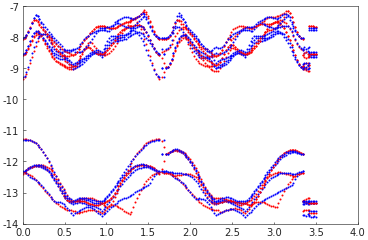

In [150]:
fig, subplot = plt.subplots()
for i in [23,24,25,26,27,28,29,30,31]:
    subplot.scatter(x,sc_bands[30+i,:]-17.6,s=1,color="red")
    subplot.scatter(x,bandenergies[i,:],s=1,color="blue")
plt.show()

In [145]:
report_fit(out, show_correl=True, modelpars=params)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 50883
    # data points      = 5280
    # variables        = 41
    chi-square         = 5308.58719
    reduced chi-square = 1.01328253
    Akaike info crit   = 110.510080
    Bayesian info crit = 379.949016
##  Warning: uncertainties could not be estimated:
[[Variables]]
    M_Es:       -9.16763530 +/- 0.01778130 (0.19%) (init = -10.6449), model_value = -10.6449
    X_Es:       -22.3435865 +/- 0.01348912 (0.06%) (init = -20.93123), model_value = -20.93123
    M_Ep:       -7.30992886 +/- 4.6556e-04 (0.01%) (init = -7.606622), model_value = -7.606622
    X_Ep:       -13.9159602 +/-        nan (nan%) (init = -13.46862), model_value = -13.46862
    M_Ese:      -1.2818e-04 +/- 5.3691e-06 (4.19%) (init = -3.20562), model_value = -3.20562
    X_Ese:      -5.82380271 +/- 0.00395524 (0.07%) (init = -8.361321), model_value = -8.361321
    one_ss:     -0.85143160 +/-        nan (nan%) (init = -0.9308703), model_value = -

In [144]:
np.min(bandenergies[27,:]-bandenergies[26,:])

2.025341